# Experiment 4: data cube experiment based on CNN-transformer.

## Libraries

In [1]:
from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR
import os
import argparse
from astropy.io import fits

import glob
import pickle
import Models
import os
import sys
import PIL
import data_loader

# Path

In [2]:
print(os.getcwd())

C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails


In [3]:
import sys, os
base_path = os.getcwd()
data_path  = os.path.join(base_path, 'data')
data_cube_path = os.path.join(data_path, 'saury2014','cubes')
fcnm_path = os.path.join(data_path, 'saury2014','fcnm')
rhi_path = os.path.join(data_path, 'saury2014','RHI')
print(data_cube_path)
print(fcnm_path)
print(rhi_path)

C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\cubes
C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\fcnm
C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\RHI


In [4]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x 101)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = os.path.join(data_cube_path, training_data_file_q0)
training_data_file_q1 = os.path.join(data_cube_path, training_data_file_q1)
training_data_file_q2 = os.path.join(data_cube_path, training_data_file_q2)
training_data_file_q3 = os.path.join(data_cube_path, training_data_file_q3)

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = os.path.join(rhi_path, rhi_file_q0)
rhi_file_q1 = os.path.join(rhi_path, rhi_file_q1)
rhi_file_q2 = os.path.join(rhi_path, rhi_file_q2)
rhi_file_q3 = os.path.join(rhi_path, rhi_file_q3)

# 3a. FCNM maps with noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'

fcnm_file_q0 = os.path.join(fcnm_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(fcnm_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(fcnm_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(fcnm_path, fcnm_file_q3)

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)

C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\cubes\Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits
C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\fcnm\fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits
C:\Users\Administrator-1\Desktop\New folder (6)\HI\ML\Experiment_4_10trails\data\saury2014\RHI\R_map_n01_pw02_vs12_512px_quarter_0_noise.fits


## Data Preparation

In [5]:
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

In [6]:
print(cube1.shape)
print(fcnm_data1.shape)
print(rhi_data1.shape)

(101, 512, 512)
(512, 512)
(512, 512)


In [7]:
dictt = {}
# cube 1
num=512*512
for i in range(0, num):
    index=i
    row_index = index//512
    column_index = index%512
    dictt[i] = (cube1[:,row_index, column_index ], [fcnm_data1[row_index, column_index], rhi_data1[row_index, column_index]], [0, row_index, column_index])

# cube 2
for i in range(num, 2*num):
    index = i-num
    row_index = index//512
    column_index = index%512
    dictt[i] = (cube2[:,row_index, column_index ], [fcnm_data2[row_index, column_index], rhi_data2[row_index, column_index]], [1, row_index, column_index])

In [8]:
# train
print(len(dictt))
test_len=len(dictt)//5
arr = np.arange(len(dictt))
np.random.shuffle(arr)
test = arr[0: test_len]
validate = arr[test_len: test_len*2]
train = arr[test_len*2: len(dictt)]

524288


In [9]:
def pict_dict(indexs, dictt):
    A = {}
    o = 0
    for i in indexs:
        values = dictt[i]
        A[o] = values
        o = o+1
    return A

In [10]:
xy_train = pict_dict(train, dictt)
xy_vali = pict_dict(validate, dictt)
xy_test = pict_dict(test, dictt)

In [11]:
print("xy_train=",len(xy_train))
print("xy_vali=",len(xy_vali))
print("xy_test=",len(xy_test))
print('all = ', len(xy_train)+len(xy_vali)+len(xy_test))

xy_train= 314574
xy_vali= 104857
xy_test= 104857
all =  524288


## Data split visualization

In [12]:
"""
    plot_split_situation: A method to plot the training , validation, and testing split.
    
    black: training data.
    green: validation data.
    red: testing data. 
    
    input Attributes
    ----------
    index : int
        the index of cube you want to show. (0, 1, 2, 3)
    xy_train: tuple
        the overall training data.
    xy_test : tuple
        the overall testing data.
    xy_vali: tuple
        the overall validation data.

"""

def plot_split_situation(index ,xy_train, xy_test, xy_vali):
    train = []
    vali = []
    test = []
    for i in range(0, len(xy_train)):
        o = xy_train.get(i)
        #print(o[2][0])
        if (o[2][0] == index):
            train.append([o[2][1], o[2][2]])
    for i in range(0, len(xy_vali)):
        o = xy_vali.get(i)
        if (o[2][0] == index):
            vali.append([o[2][1], o[2][2]])
    for i in range(0, len(xy_test)):
        o = xy_test.get(i)
        if (o[2][0] == index ):
            test.append([o[2][1], o[2][2]])
    #print(train)
    print(len(train)+len(vali)+len(test) == 512*512)
    im = np.zeros((512,512,3), np.uint8)
    #print(im.shape)
    #for i in range (0, len(train)):
    #    point = train[i]
    #    im[point[0], point[1], :][0] = 255
    for i in range (0, len(vali)):
        point = vali[i]
        im[point[0], point[1], :][1] = 255
    for i in range (0, len(test)):
        point = test[i]
        im[point[0], point[1] , :][2] =255
    plt.figure(figsize=(10, 10))
    plt.imshow(im)
    plt.title(f'{index} th datacube')
    plt.show()

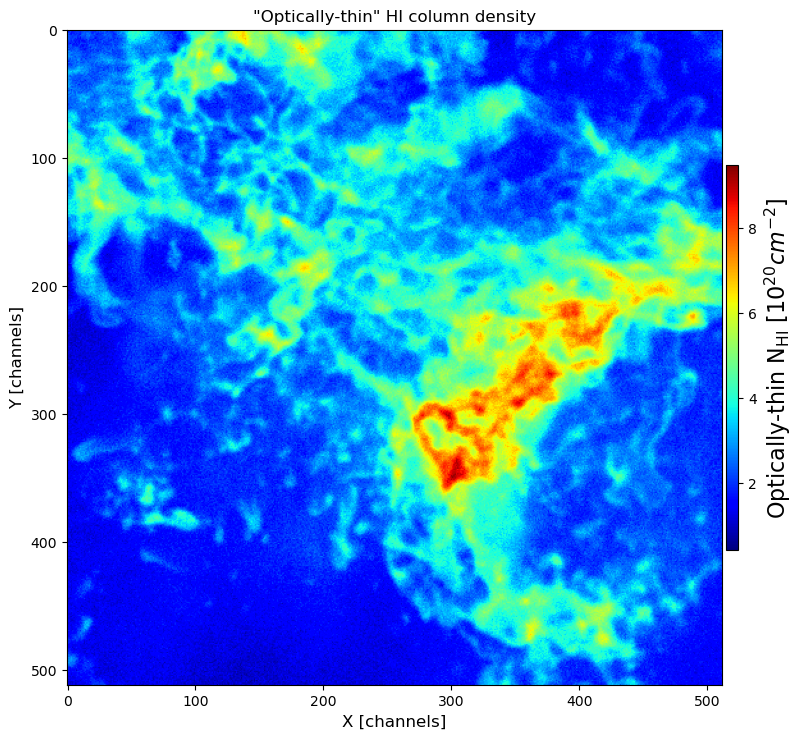

In [13]:
data, header = fits.getdata(training_data_file_q0, header=True)
# Sum along 101 velocity channels
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI # In unit of 10^20 cm-2
plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='jet')
cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)
plt.title('\"Optically-thin\" HI column density')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

True


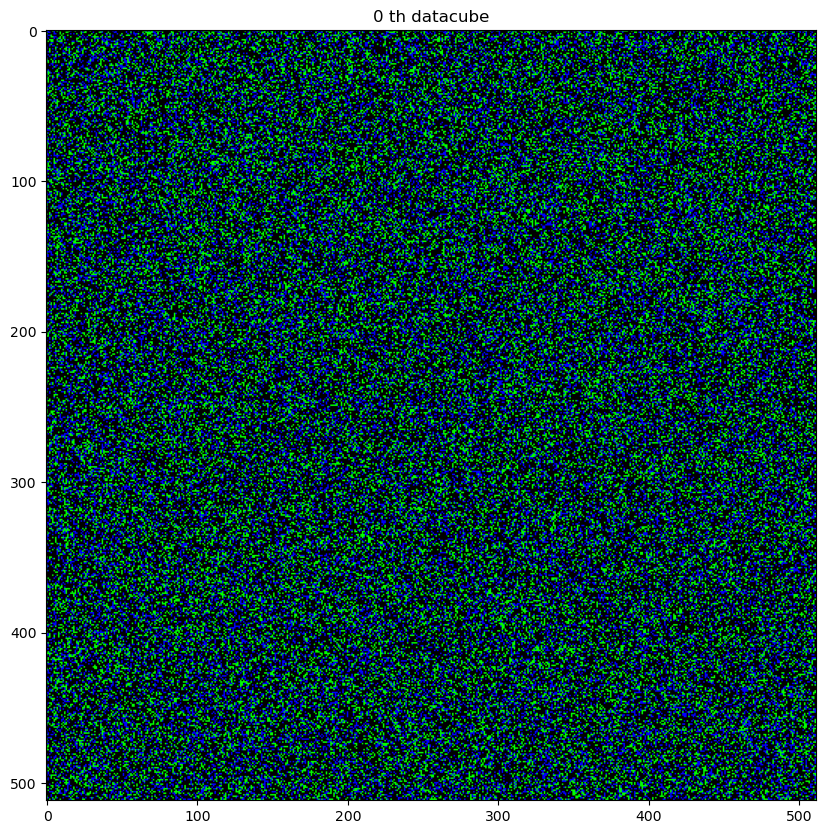

In [14]:
plot_split_situation(0, xy_train, xy_test, xy_vali)

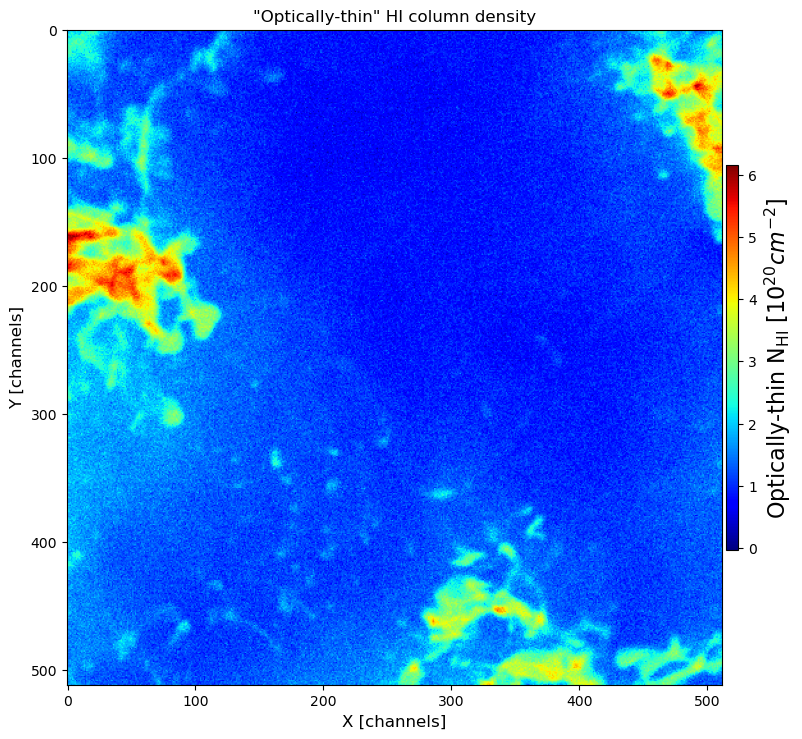

In [15]:
data, header = fits.getdata(training_data_file_q1, header=True)
# Sum along 101 velocity channels
WHI = np.sum(data, axis=0)
NHI_thin = 1.8224 * 1.e-2 * WHI # In unit of 10^20 cm-2
plt.figure(figsize=(10,10))
plt.imshow(NHI_thin, cmap='jet')
cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Optically-thin N$_\mathrm{HI}$ [10$^{20} cm^{-2}$]', size=16)
plt.title('\"Optically-thin\" HI column density')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

True


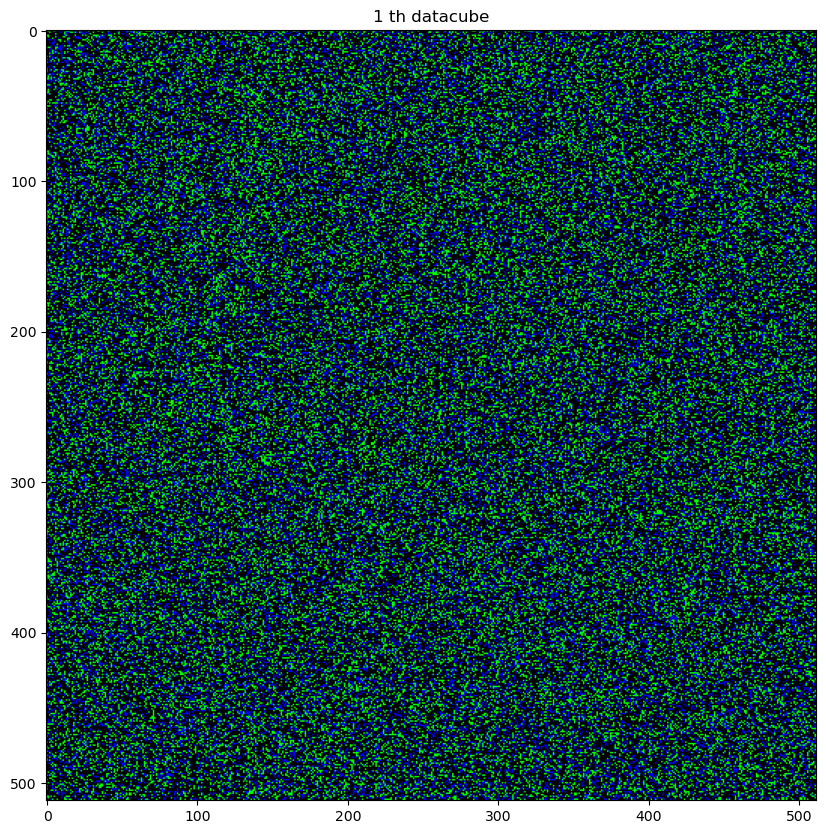

In [16]:
plot_split_situation(1, xy_train, xy_test, xy_vali)

## Model Training and Evaluation 

In [17]:
# train 
def train(epoch):
    """
    Train the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    train_loss/total: The mean MSE in an epoch. 
        
    """
    global model
    model.train()
    train_loss = 0
    total = 0
    for index, (inputs, values) in enumerate(train_loader):
        inputs = inputs.float()
        values = values.float()
        inputs, values = inputs.to(device), values.to(device)
        # forward
        outputs = model(inputs)
        loss = loss_function(outputs, values)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        train_loss = train_loss + (loss.item()*values.size(0)) 
        total += values.size(0)
    print(f'total loss in epoch {epoch}= ', train_loss)
    return train_loss/total

In [18]:
def validation(epoch, PEV):
    """
    validate the model.
    Parameters
    ----------
    PEV: String
        positional encoding vector method, used for naming the weights file. 
    epoch : int.
        the index of epoch.

    Returns
    -------
    error: The mean MSE in validation set. 
        
    """
    global model
    model.eval()
    test_loss = 0
    total = 0
    global best_err
    with torch.no_grad():
        for index, (inputs, values) in enumerate(valid_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward
            outputs = model(inputs)
            loss = loss_function(outputs, values)
            test_loss = test_loss + (loss.item()*values.size(0))
            total += values.size(0)
    # Save checkpoint.
    error =  test_loss / total
    #print(f"validation MSE in epoch {epoch}= ", error)
    if error < best_err:
        print('best_err:', error, 'Saving..')
        state = {'net': model.state_dict(),
                 'err': error,
                 'optimizer_state_dict': optimizer.state_dict(),
                 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'./checkpoint/{PEV}.pth')
        best_err = error
    return error

In [19]:
def test(epoch):
    """
    test the model.
    Parameters
    ----------
    epoch : int.
        the index of epoch.
    Returns
    -------
    error: The mean MSE in test set. 
    """
    global model
    model.eval()
    test_loss = 0
    total = 0
    with torch.no_grad():
        for index, (inputs, values) in enumerate(test_loader):
            inputs = inputs.float()
            values = values.float()
            inputs, values = inputs.to(device), values.to(device)
            # forward 
            outputs = model(inputs)
            #outputs = outputs.view(outputs[0], 1, outputs[1])
            loss = loss_function(outputs, values)
            test_loss =test_loss+ (loss.item()* values.size(0))
            total += values.size(0)
        return test_loss/total

## Start 10 trail Training

In [20]:
"""
    validate_model: evaluate model performance.
    
    input Attributes
    ----------
    PEV: string
        the positional encoding methods.
    in_channels: int
        number of intput channels
    input_row:  int 
        number of intput rows.
    input_column:int
        number of intput columns
    num_output: int
        number of CNN outputs .
    drop_out_rate: float
        rate to dorp out in the final layers.
    lpe : boolean 
        whether to add learnable PEV to the inputs of CNN.
        
    return attributes
    ----------
    validation_error: float
        the best validation error in that trail
    test_error: float
        the MSE error corespond to the lowest validation MSE.
"""


def validate_model(PEV,
                   num_output=2,
                   in_channels=1,
                   input_row = 1,
                   input_column=101,
                   drop_out_rate=0.0,
                   lpe=False):
    global model
    model =  Models.cnn_transformer_small(num_output=num_output,
                             in_channels=in_channels,
                             input_row = input_row,
                             input_column=input_column,
                             drop_out_rate=drop_out_rate,
                             lpe=lpe)
    best_err = 100000
    checkpoint = torch.load(f'./checkpoint/{PEV}.pth',map_location=torch.device('cuda:0'))
    model.load_state_dict(checkpoint['net'])
    model.to(device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    validation_error = validation(epoch, PEV)
    test_error = test(epoch)
    return validation_error, test_error

In [21]:
"""
    trail: do each trail.
    
    input Attributes
    ----------
    num_epoch: int
        number of epoch
    in_channels: int
        number of intput channels
    input_row:  int 
        number of intput rows.
    input_column:int
        number of intput columns
    num_output: int
        number of CNN outputs .
    drop_out_rate: float
        rate to dorp out in the final layers.
    lpe : boolean 
        whether to add learnable PEV to the inputs of CNN.
"""


def trail(PEV, num_epoch,
          num_output=2,
          in_channels=1,
          input_row = 1,
          input_column=101,
          drop_out_rate=0,
          lpe=False):
    
    global vali
    global testing
    global scheduler
    global learning_rate
    lr = learning_rate
    #define savor
    global train_trails
    global validate_trails
    global test_trails
    global optimizer
    lr=learning_rate
    global best_err
    best_err = 100000
    global model
    model =  Models.cnn_transformer_small(num_output=num_output,
                             in_channels=in_channels,
                             input_row = input_row,
                             input_column=input_column,
                             drop_out_rate=drop_out_rate,
                             lpe=lpe)
    optimizer = torch.optim.SGD(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                     milestones = [48], 
                                                     gamma=0.1, last_epoch=-1, 
                                                     verbose=False)
    model.to(device)
    for epoch in range(num_epoch):
        train_err = train(epoch)
        vali_err = validation(epoch,PEV)
        scheduler.step()
        test_err = test(epoch)
        # save data
        train_trails.append(train_err)
        validate_trails.append(vali_err)
        test_trails.append(test_err)
    # final test
    validation_error,test_error = validate_model(PEV, num_output=num_output,
                                                 in_channels=in_channels,
                                                 input_row = input_row,
                                                 input_column=input_column,
                                                 drop_out_rate=drop_out_rate,
                                                 lpe=lpe)
    print("test err=",test_error)
    vali.append(validation_error)
    testing.append(test_error)

In [22]:
"""
    trail_10: conduct 10 trails.
    
    input Attributes
    ----------
    PEV: STring 
        positional encoding vector
    num_trial : int
        number of trails
    num_epoch: int
        number of epoch
    in_channels: int
        number of intput channels
    input_row:  int 
        number of intput rows.
    input_column:int
        number of intput columns
    num_output: int
        number of CNN outputs .
    drop_out_rate: float
        rate to dorp out in the final layers.
    lpe : boolean 
        whether to add learnable PEV to the inputs of CNN.
"""
def trail_10(PEV, 
             num_trial,
             num_epoch, 
             #
             in_channels,
             input_row,
             input_column,
             num_output=2,
             drop_out_rate=0,
             lpe=False):
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    global model
    global loss_function
    global best_err
    loss_function = nn.MSELoss()
    
    for i in range (0, num_trial):
        print(f'start the {i}th trial:')
        # model initialization
        
        trail(PEV, num_epoch = num_epoch,
              input_row = input_row,
              in_channels = in_channels,
              input_column=input_column,
              drop_out_rate=drop_out_rate,
              lpe=lpe,
              num_output=num_output
             )

## Results display methods

In [23]:
def validation_performance(vali):
    x = vali
    plt.figure(figsize=(7,5))
    plt.title('validation performance')
    plt.plot(x, label='validation MSE',marker='o')
    plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
    plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()
    print("validation mean=",np.mean(x))
    print("validation std=",np.std(x))

In [24]:
def test_performance(testing):
    x = testing
    plt.figure(figsize=(7,5))
    plt.title('testing performance')
    plt.plot(x, label='testing MSE',marker='o')
    plt.plot([], [], ' ', label=f"mean={round(np.mean(x),6)}")
    plt.plot([], [], ' ', label=f"std={round(np.std(x),6)}")
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()
    print("testing mean=",np.mean(x))
    print("testing std=",np.std(x))

In [25]:
def vali_testing_performance_show(vali, testing):
    x1 = vali
    x2 = testing
    plt.figure(figsize=(7,5))
    plt.title('Two in one')
    plt.plot(x1, label='vaidation_MSE',marker='o')
    plt.plot(x2, label='tesing_MSE',marker='o')
    plt.xlabel('Trail')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid()
    plt.show()

## Save csv methdos

In [26]:
"""
    save_csv: save CSV files.
    
    input Attributes
    ----------
    vali : np array 
        the validation performance in each trail.
    testing: array
        the testing performance in each trail.
    file_name_1: String
        csv file name for storing the testing and validation data.
    file_name_2:  String 
        csv file name for storing the process data.
        
    hiddern inputs
    ----------
    train_trails: global array
        the training process.
    validate_trails:
        the validation prcess.
    test_trails:
        the testing process.
"""

def save_csv(vali, testing, file_name_1, file_name_2):
    x1 = np.array(vali).reshape(1, -1)
    x2 = np.array(testing).reshape(1, -1)
    two = np.vstack((x1,x2))
    df = pd.DataFrame(two).T
    df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\" + file_name_1)
    #
    x3 = np.array(train_trails).reshape(1, -1)
    x4 = np.array(validate_trails).reshape(1, -1)
    x5 = np.array(test_trails).reshape(1, -1)
    three = np.vstack((x3,x4,x5))
    df = pd.DataFrame(three).T
    df.to_csv(os.path.join(os.getcwd(),"training_process") + "\\"+ file_name_2)

## Training: 10 trails

In [27]:
"""
    start_10trails: conduct 10 trails training
    black: training data.
    green: validation data.
    red: testing data. 
    
    input Attributes
    ----------
    PEV : string
        data representation methods
    batch_size: int
        the size of the batch
    xy_train: tuple
        the overall training data.
    xy_test : tuple
        the overall testing data.
    xy_vali: tuple
        the overall validation data.
    lpe:  boolean 
        whether add learnable PEV to original vector.
"""


def start_10trails(PEV, batch_size, xy_train, xy_vali, xy_test, lpe):
    global device
    global model
    global learning_rate
    global train_loader
    global valid_loader
    global test_loader
    global vali
    global testing
    global train_trails
    global validate_trails
    global test_trails
    if(PEV==None):
        PEV = 'original_vector'
    if(lpe==True):
        PEV = "learnable_PEV"
    # the savier of best validation performance and coresponding testing performance.
    vali = []
    testing = []
    # saver for each trials
    train_trails = []
    validate_trails =[]
    test_trails = []
    
    learning_rate = 0.1
    # initialize dataset
    dataset_train = data_loader.spectra_cube_loader(xy_train, 
                                           transform=data_loader.ToTensor(),
                                           target_transform=data_loader.ToTensor(),
                                           pe=PEV)
    dataset_val = data_loader.spectra_cube_loader(xy_vali, 
                                         transform=data_loader.ToTensor(),
                                         target_transform=data_loader.ToTensor(),
                                         pe=PEV)
    dataset_test = data_loader.spectra_cube_loader(xy_test,
                                          transform=data_loader.ToTensor(),
                                          target_transform=data_loader.ToTensor(),
                                          pe=PEV)
    # initialize data loader
    train_loader = torch.utils.data.DataLoader(dataset = dataset_train,
                                           batch_size = batch_size,
                                           shuffle =True)

    valid_loader = torch.utils.data.DataLoader(dataset = dataset_val,
                                           batch_size = batch_size,
                                           shuffle =False)

    test_loader = torch.utils.data.DataLoader(dataset = dataset_test,
                                          batch_size = batch_size,
                                          shuffle =False)
    
    # test data loader
    val = iter(test_loader)
    A,B = next(val)
    print(f'{PEV},A.shape=',A.shape)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    trail_10(PEV,
             num_trial = 10,
             num_epoch = 60, 
             #
             in_channels = A.shape[1],
             input_row=A.shape[2],
             input_column=A.shape[3],
             num_output=2,
             drop_out_rate=0.3,
             lpe=lpe)
    validation_performance(vali)
    test_performance(testing)
    vali_testing_performance_show(vali, testing)
    file_name_1 = f'{PEV}.csv'
    file_name_2 = f'{PEV}_process.csv'
    save_csv(vali, testing, file_name_1, file_name_2)

### concatenating index PEV at axis 1

In [28]:
start_10trails("index_concate", 100, xy_train, xy_vali, xy_test, False)

index_concate,A.shape= torch.Size([100, 1, 2, 101])
start the 0th trial:


KeyboardInterrupt: 